In [45]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits import mplot3d

In [46]:
np.random.seed(1234)
tf.random.set_seed(1234)

In [47]:
class planet:
  def __init__(self, position, momentum, mass):
    self.position = position
    self.momentum = momentum
    self.mass = mass

  def drdt(self):
    drdt = self.momentum/self.mass
    return drdt


def dpdt(planet1, planet2):
  m1 = planet1.mass
  m2 = planet2.mass
  r1 = planet1.position
  r2 = planet2.position
  drdt = g* m1*m2 * ( r1-r2) / np.linalg.norm(r1-r2)**1.5
  return drdt

In [48]:
def Hamiltonian_3body(t,inp):

  m1 = m2 = m3 = 1

  r1 = np.array([inp[0], inp[1]])
  p1 = np.array([inp[2], inp[3]])

  r2 = np.array([inp[4], inp[5]])
  p2 = np.array([inp[6], inp[7]])
  
  r3 = np.array([inp[8], inp[9]])
  p3 = np.array([inp[10], inp[11]])

  planet1 = planet(r1, p1, m1)
  planet2 = planet(r2, p2, m2)
  planet3 = planet(r3, p3, m3)

  dr1dt = planet1.drdt()
  dr2dt = planet2.drdt()
  dr3dt = planet3.drdt()

  dp1dt = -1* (dpdt(planet1, planet2) + dpdt(planet1, planet3))
  dp2dt = -1* (dpdt(planet2, planet1) + dpdt(planet2, planet3))
  dp3dt = -1* (dpdt(planet3, planet1) + dpdt(planet3, planet2))

  return np.concatenate((dr1dt, dp1dt, dr2dt, dp2dt, dr3dt, dp3dt))

In [49]:
def rotation(x, theta):
  c = np.cos(theta)
  s = np.sin(theta)
  rotation_matrix = np.array([[c, -s], [s, c]])
  rotated = np.matmul(rotation_matrix, x)
  return np.squeeze(rotated)

  
def get_initial_cond():
  '''The code for this function is from Greydanus et al.'''
  min_radius = 0.9
  max_radius = 1.2
  nu = 2e-1
  p1 = 2*np.random.rand(2) - 1
  r = np.random.rand() * (max_radius-min_radius) + min_radius

  p1 *= r/np.sqrt( np.sum((p1**2)) )
  p2 = rotation(p1, theta=2*np.pi/3)
  p3 = rotation(p2, theta=2*np.pi/3)

  # # velocity that yields a circular orbit
  v1 = rotation(p1, theta=np.pi/2)
  v1 = v1 / r**1.5
  v1 = v1 * np.sqrt(np.sin(np.pi/3)/(2*np.cos(np.pi/6)**2)) # scale factor to get circular trajectories
  v2 = rotation(v1, theta=2*np.pi/3)
  v3 = rotation(v2, theta=2*np.pi/3)

  # make the circular orbits slightly chaotic
  v1 *= 1 + nu*(2*np.random.rand(2) - 1)
  v2 *= 1 + nu*(2*np.random.rand(2) - 1)
  v3 *= 1 + nu*(2*np.random.rand(2) - 1)

  initial_cond = np.concatenate((p1, v1, p2, v2, p3, v3))
  return initial_cond

In [50]:
three_body_data = np.zeros((30, 12, 301))
g = 1

for i in range(30):
  initial_cond = get_initial_cond()
  sol = solve_ivp(Hamiltonian_3body, [0,3], initial_cond, t_eval = np.linspace(0,3,301))
  three_body_data[i,:,:] = sol['y']

In [51]:
inputs = three_body_data[:25,:,:] 

window_size = 2
num_windows = 301//window_size
remainder = (301 - 1)%window_size

def preprocess(A):
    if remainder!=0:  
      Q_truncated = Q[:,:-remainder]
    else:
      Q_truncated = Q

    Q_inp = Q_truncated[:,:-1]
    Q_inp = Q_inp.reshape((-1, window_size))

    Q_tru = Q_truncated[:,1:]
    Q_tru = Q_tru.reshape((-1, window_size))

    return Q_inp, Q_tru

PQ_tru = []
PQ_inp = []

for i in range(12):
    Q = inputs[:,i,:]
    Q_inp,Q_true = preprocess(Q)
    PQ_inp.append(Q_inp)
    PQ_tru.append(Q_true)
    print(Q_inp.shape, Q_true.shape)

PQ_tru = np.stack((PQ_tru[0],PQ_tru[1],PQ_tru[2],PQ_tru[3],PQ_tru[4],PQ_tru[5],PQ_tru[6],PQ_tru[7],PQ_tru[8],PQ_tru[9],PQ_tru[10],PQ_tru[11]),axis = -1)
PQ_inp = np.stack((PQ_inp[0],PQ_inp[1],PQ_inp[2],PQ_inp[3],PQ_inp[4],PQ_inp[5],PQ_inp[6],PQ_inp[7],PQ_inp[8],PQ_inp[9],PQ_inp[10],PQ_inp[11]),axis = -1)
print(PQ_tru.shape)
print(PQ_inp.shape)

(3750, 2) (3750, 2)
(3750, 2) (3750, 2)
(3750, 2) (3750, 2)
(3750, 2) (3750, 2)
(3750, 2) (3750, 2)
(3750, 2) (3750, 2)
(3750, 2) (3750, 2)
(3750, 2) (3750, 2)
(3750, 2) (3750, 2)
(3750, 2) (3750, 2)
(3750, 2) (3750, 2)
(3750, 2) (3750, 2)
(3750, 2, 12)
(3750, 2, 12)


In [52]:
class LSTM_model(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.lstm = tf.keras.layers.LSTM(100, return_sequences=True, dropout = 0.1)
    self.dense = tf.keras.layers.Dense(12)

  def call(self, inputs):
    x = self.lstm(inputs)
    output = self.dense(x)
    return output

  def loss(self, predictions, truth):
    return tf.reduce_mean((predictions-truth)**2)

In [53]:
model = LSTM_model()
input = tf.random.normal([32,10,12]) #batch_sz, window_sz, num_features
output = model(input)

In [54]:
model.summary()
print(output.shape)

Model: "lstm_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               multiple                  45200     
                                                                 
 dense_5 (Dense)             multiple                  1212      
                                                                 
Total params: 46,412
Trainable params: 46,412
Non-trainable params: 0
_________________________________________________________________
(32, 10, 12)


In [55]:
model = LSTM_model()


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

num_epochs = 200
batch_size = 512
num_batches = PQ_inp.shape[0]//batch_size
loss_list = []
for i in range(num_epochs):
  batch_loss = []   
  for j in range(num_batches):
    start = j*batch_size
    end   = (j+1)*batch_size
    with tf.GradientTape() as tape:
      y_pred = model.call(PQ_inp[start:end,:,:])
      loss = model.loss(y_pred, PQ_tru[start:end,:,:])
    
    gradients = tape.gradient(loss, model.trainable_variables)
    #print(gradients)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    batch_loss.append(loss)
  loss_list.append(sum(batch_loss)/len(batch_loss))
  if i % 50 == 0:
    print(f"Loss on training set after {i} training steps: {sum(batch_loss)/len(batch_loss)}")

Loss on training set after 0 training steps: 0.508541464805603
Loss on training set after 50 training steps: 0.14907029271125793
Loss on training set after 100 training steps: 0.07720661163330078
Loss on training set after 150 training steps: 0.046610355377197266


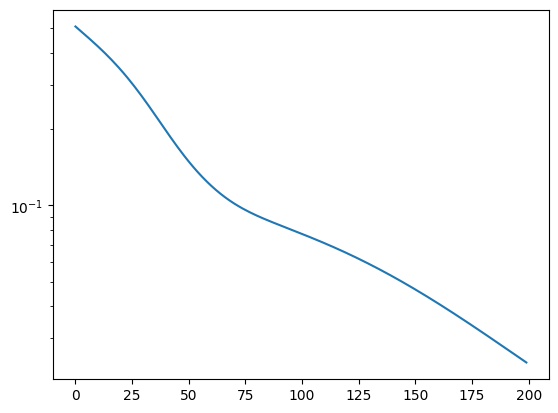

In [56]:
plt.semilogy(loss_list)

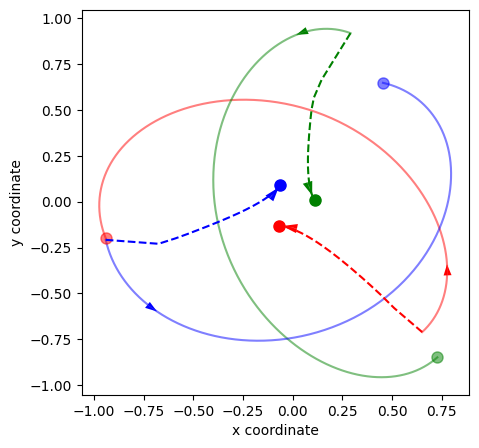

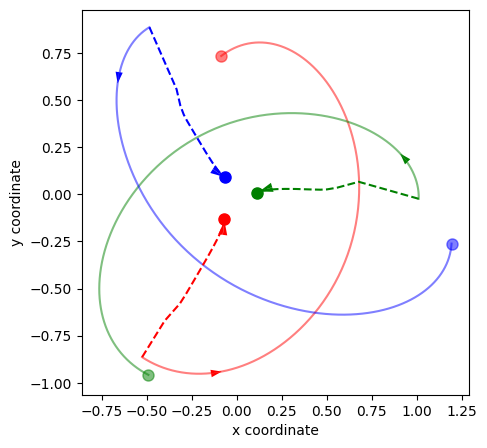

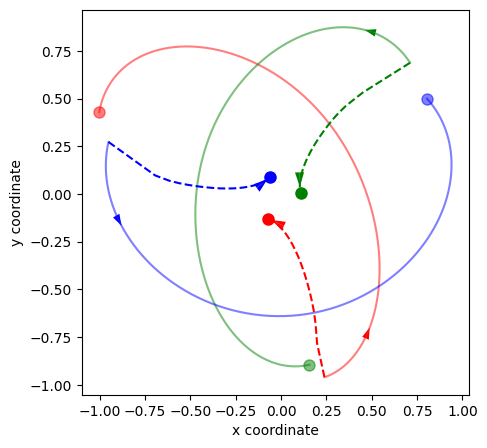

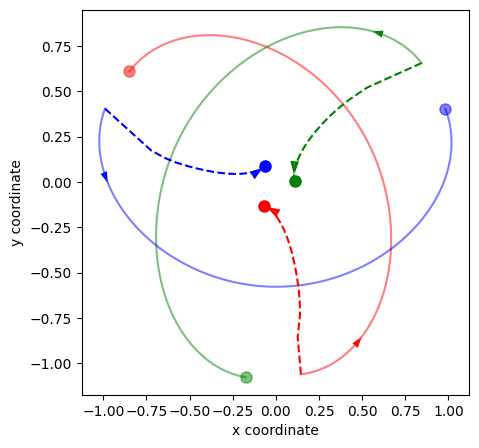

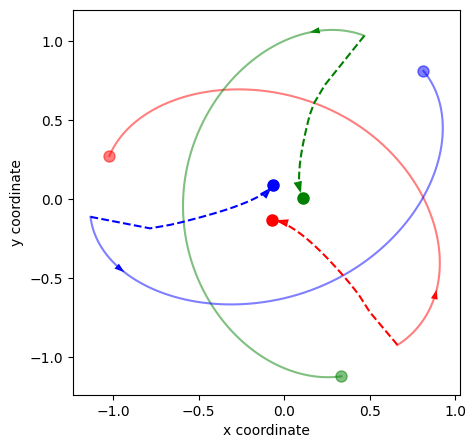

[1.0714282069394478, 1.0377454485633502, 1.0727247964271485, 1.0680693592331965, 1.076898911575575]
1.0653733445477436


In [61]:
test_err_sum_3b = []
for i in range(25,30):

    test_inp =  three_body_data[i,:,0]

    q1_list = []
    q2_list = []
    q3_list = []
    q4_list = []
    q5_list = []
    q6_list = []
    q7_list = []
    q8_list = []
    q9_list = []
    q10_list = []
    q11_list = []
    q12_list = []
    main_list = np.array(three_body_data[i,:,0])
    #x0 = Q[27,0]
    #y0 = P[27,0]
    for j in range(300):
        inp = tf.convert_to_tensor(np.array([[test_inp]]))
        out = model.call(inp).numpy()
        test_inp = out[0,0,:]

        main_list = np.vstack((main_list,test_inp))

    main_list = main_list.T
    plt.figure(figsize = (5,5))
    plt.plot(three_body_data[i,0,:],three_body_data[i,1,:],'-r', alpha = 0.5)
    plt.plot(three_body_data[i,4,:],three_body_data[i,5,:],'-g',alpha = 0.5)
    plt.plot(three_body_data[i,8,:],three_body_data[i,9,:],'-b',alpha = 0.5)
    plt.plot(three_body_data[i,0,-1],three_body_data[i,1,-1],'or', markersize= 8,alpha = 0.5)
    plt.plot(three_body_data[i,4,-1],three_body_data[i,5,-1],'og', markersize= 8,alpha = 0.5)
    plt.plot(three_body_data[i,8,-1],three_body_data[i,9,-1],'ob', markersize= 8,alpha = 0.5)
    plt.arrow(three_body_data[i,0,50],three_body_data[i,1,50], three_body_data[i,0,51] - three_body_data[i,0,50], three_body_data[i,1,51]-three_body_data[i,1,50], shape = 'full',lw=0, length_includes_head=True, head_width=0.04,color = 'r')
    plt.arrow(three_body_data[i,4,40],three_body_data[i,5,40], three_body_data[i,4,41] - three_body_data[i,4,40], three_body_data[i,5,41]-three_body_data[i,5,40], shape = 'full',lw=0, length_includes_head=True, head_width=0.04,color = 'g')
    plt.arrow(three_body_data[i,8,50],three_body_data[i,9,50], three_body_data[i,8,51] - three_body_data[i,8,50], three_body_data[i,9,51]-three_body_data[i,9,50], shape = 'full',lw=0, length_includes_head=True, head_width=0.04,color = 'b')

    plt.plot(main_list[0,:],main_list[1,:],'--r')
    plt.plot(main_list[4,:],main_list[5,:],'--g')
    plt.plot(main_list[8,:],main_list[9,:],'--b')
    plt.plot(main_list[0,-1],main_list[1,-1],'or', markersize= 8)
    plt.plot(main_list[4,-1],main_list[5,-1],'og', markersize= 8)
    plt.plot(main_list[8,-1],main_list[9,-1],'ob', markersize= 8)
    plt.arrow(main_list[0,50],main_list[1,50], main_list[0,51] - main_list[0,50], main_list[1,51]-main_list[1,50], shape = 'full',lw=0, length_includes_head=True, head_width=0.05,color = 'r')
    plt.arrow(main_list[4,40],main_list[5,40], main_list[4,41] - main_list[4,40], main_list[5,41]-main_list[5,40], shape = 'full',lw=0, length_includes_head=True, head_width=0.05,color = 'g')
    plt.arrow(main_list[8,50],main_list[9,50], main_list[8,51] - main_list[8,50], main_list[9,51]-main_list[9,50], shape = 'full',lw=0, length_includes_head=True, head_width=0.05,color = 'b')

    plt.xlabel('x coordinate')
    plt.ylabel('y coordinate')
    plt.show()
    sum_square = []
    sum_square_or = []

    for z in range(12):
        q = main_list[z,:]
        q_true = three_body_data[i,z,:]
        sum_square.append(np.sum((q- q_true)**2))
        sum_square_or.append(np.sum(q_true**2))
        
    test_err_sum_3b.append(np.sqrt(np.sum(np.array(sum_square)))/np.sqrt(np.sum(np.array(sum_square_or))))
print(test_err_sum_3b)
print(np.mean(test_err_sum_3b))
